### Installing transformer library

In [ ]:
!pip install transformers

### Importing necessaries libraries...

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys

import numpy as np
import random as rn
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam, AdamW
from torch.nn.utils import clip_grad_norm_

from transformers import AutoModel, BertTokenizerFast
from IPython.display import clear_output
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Loading bert pre-trained model and tokenizer

In [2]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased', do_lower_case=True)

#### Important parameters

In [3]:
#maximum number of tokens for data representation (the lower, the poorer representation but less memory)
MAX_TOKENS = 512 #could be 128 but 512 is the maximum size allowed
BATCH_SIZE = 32 #the higher is better but requires more memory
EPOCHS = 5 #the higher is better but requires more time to complete the training process
THRESHOLD = 0.5

#### Mounting Google drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

#### Setting up data path

In [5]:
root_data_path = 'file path'
#root_data_path = '/projets/sig/mullah/nlp/cv/data/corpus_splits/'
os.listdir(root_data_path)

['Skill_test',
 'CV_train',
 'Skill_val',
 'test',
 'train.csv',
 'CV_test',
 'test.csv',
 'train',
 'val.csv',
 'val',
 'Skill_train',
 'CV_val',
 'normlized_classes.txt']

#### Loading train, validation, and test datasets

In [6]:
train_data = pd.read_csv(os.path.join(root_data_path, "train.csv"), header=0, delimiter=",")
val_data = pd.read_csv(os.path.join(root_data_path, "val.csv"), header=0, delimiter=",")
test_data = pd.read_csv(os.path.join(root_data_path, "test.csv"), header=0, delimiter=",")

#### Checkhing some training and validation data

In [7]:
train_data.head(5)

,Id,Text,Tags
0,6589,"Operations Manager Operations <span class=""hl""...",['Software_Developer']
1,15618,"Network Administratoir <span class=""hl"">Networ...",['Network_Administrator']
2,6751,"IT Delivery Manager <span class=""hl"">IT</span>...",['Project_manager']
3,29164,"Web Developer <span class=""hl"">Web</span> <spa...","['Web_Developer', 'Software_Developer']"
4,3288,Self-Employed Self-Employed Self-Employed - Se...,"['Web_Developer', 'Software_Developer', 'Front..."


In [8]:
val_data.head(5)

,Id,Text,Tags
0,4453,Freelance Web Developer & Graphic Designer Fre...,"['Web_Developer', 'Software_Developer']"
1,7144,"IT Project Manager <span class=""hl"">IT</span> ...",['Project_manager']
2,3891,iOS SOFTWARE ENGINEER iOS SOFTWARE ENGINEER iO...,"['Software_Developer', 'Front_End_Developer']"
3,7374,"Senior Project Manager Senior <span class=""hl""...",['Project_manager']
4,28916,"Senior Web Consultant Senior <span class=""hl"">...",[]


#### Checking some testing data

In [9]:
test_data.head(5)

,Id,Text,Tags
0,4911,"Front End Web Developer <span class=""hl"">Front...","['Web_Developer', 'Software_Developer', 'Front..."
1,22728,Data Scientist Data Scientist Looking for job ...,"['Python_Developer', 'Software_Developer']"
2,19906,Teaching Associate (Part time) Teaching Associ...,"['Python_Developer', 'Software_Developer', 'We..."
3,3599,"Front End Developer Internship <span class=""hl...","['Software_Developer', 'Front_End_Developer']"
4,18293,"Python Tutor <span class=""hl"">Python</span> Tu...","['Software_Developer', 'Web_Developer']"


#### Initializing random seed values to stabilize the outcomes.

In [10]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

#### Experimenting with train, validation, and testset 
**Probably** with a small subset to avoid memory overflow. But, if you have larger computational resources (GPU), you can use whole dataset

In [11]:
train_subset = train_data
validation_subset = val_data
test_subset = test_data

#train_subset = train_data[:500]
#validation_subset = val_data[:500]
#test_subset = test_data[:500]

#### Separating the data (review texts) and their Labels

In [12]:
train_texts, train_labels = train_subset['Text'], train_subset['Tags']
validation_texts, validation_labels = validation_subset['Text'], validation_subset['Tags']
test_texts, test_labels = test_subset['Text'], test_subset['Tags']

In [13]:
train_texts[:5]

0    Operations Manager Operations <span class="hl"...
1    Network Administratoir <span class="hl">Networ...
2    IT Delivery Manager <span class="hl">IT</span>...
3    Web Developer <span class="hl">Web</span> <spa...
4    Self-Employed Self-Employed Self-Employed - Se...
Name: Text, dtype: object

Ok, train\_texts are in pandas and not clean. There are a lot of artifacts, like html tags

In [14]:
train_labels[:5]

0                               ['Software_Developer']
1                            ['Network_Administrator']
2                                  ['Project_manager']
3              ['Web_Developer', 'Software_Developer']
4    ['Web_Developer', 'Software_Developer', 'Front...
Name: Tags, dtype: object

Two problems here: </br>
 **Multiple labels** for each sample</br>
 **Labels** are in string of list format</br>
We have to solve these two problems, convert the string of list to list format and binarized the multilabel of samples

#### Encoding labels of train, validation, and test set
**Converting** string of list to list using *literal_eval* function. </br>
Using MultiLabelBinarizer to encode the multiclass multilabel target


In [15]:
train_labels = [literal_eval(labels) for labels in train_labels]
validation_labels = [literal_eval(labels) for labels in validation_labels]
test_labels = [literal_eval(labels) for labels in test_labels]

Fitting the MultiLabelBinarizer on the train subset labels

In [16]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(train_labels)

MultiLabelBinarizer()

In [17]:
print (multilabel_binarizer.classes_)

['Database_Administrator' 'Front_End_Developer' 'Java_Developer'
 'Network_Administrator' 'Project_manager' 'Python_Developer'
 'Security_Analyst' 'Software_Developer' 'Systems_Administrator'
 'Web_Developer']


In [18]:
train_labels_binarized = multilabel_binarizer.transform(train_labels)
validation_labels_binarized = multilabel_binarizer.transform(validation_labels)
test_labels_binarized = multilabel_binarizer.transform(test_labels)

In [19]:
train_labels_binarized[:5]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 1]])

In [20]:
validation_labels_binarized[:5]

array([[0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [21]:
test_labels_binarized[:5]

array([[0, 1, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1]])

In [22]:
multilabel_binarizer.inverse_transform(train_labels_binarized[:5])

[('Software_Developer',),
 ('Network_Administrator',),
 ('Project_manager',),
 ('Software_Developer', 'Web_Developer'),
 ('Front_End_Developer', 'Software_Developer', 'Web_Developer')]

#### Checking the size of the datasets (train, validation, test) 

In [23]:
len(train_texts), len(train_labels_binarized), len(validation_texts), len(validation_labels_binarized), len(test_texts), len(test_labels_binarized)

(17870, 17870, 5957, 5957, 5956, 5956)

#### Visualizing number of tokens in train, validation, and test sets

Token indices sequence length is longer than the specified maximum sequence length for this model (1367 > 512). Running this sequence through the model will result in indexing errors


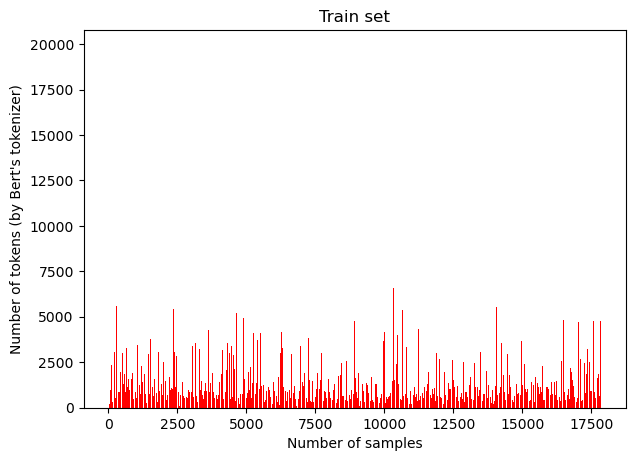

In [302]:
#Train set

sentences = [len(tokenizer.tokenize(sent)) for sent in train_texts]
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1, len(sentences)+1), sentences, color = ['red'])
plt.gca().set(title='Train set', xlabel="Number of samples", ylabel="Number of tokens (by Bert's tokenizer)");

In [303]:
#Validation set
#sentences = [len(tokenizer.tokenize(sent)) for sent in validation_texts]
#plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
#plt.bar(range(1, len(sentences)+1), sentences, color = ['red'])
#plt.gca().set(title='Validation set', xlabel="Number of samples", ylabel="Number of tokens (by Bert's tokenizer)");

In [304]:
#Test set
#sentences = [len(tokenizer.tokenize(sent)) for sent in test_texts]
#plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
#plt.bar(range(1, len(sentences)+1), sentences, color = ['red'])
#plt.gca().set(title='Test set', xlabel="Number of samples", ylabel="Number of tokens (by Bert's tokenizer)");

#### Tokenize and Encoding
Token embedding, Attention, and Positional encoding

In [24]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_texts.tolist(),
    max_length = MAX_TOKENS, #keeping the maximum number of tokens to be 128
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    validation_texts.tolist(),
    max_length = MAX_TOKENS, #keeping the maximum number of tokens to be 128
    padding=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_texts.tolist(),
    max_length = MAX_TOKENS,
    padding=True,
    truncation=True
)

#### Looking up the Token sequence, Mask, and Labels

In [25]:
train_sequence = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
#train_y = torch.tensor(np.array(train_labels).reshape(-1, 1)).float()
train_y = torch.tensor(train_labels_binarized.tolist(), dtype=torch.float32)

val_sequence = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
#val_y = torch.tensor(np.array(validation_labels).reshape(-1, 1)).float()
val_y = torch.tensor(validation_labels_binarized.tolist(), dtype=torch.float32)

test_sequence = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
#test_y = torch.tensor(np.array(test_labels).reshape(-1, 1)).float()
test_y = torch.tensor(test_labels_binarized, dtype=torch.float32)

#### Setting Up Data Loader
**Random sampler** for train set and **Sequential sampler** for validation and test sets.

In [26]:
#training set
#wrap tensors
train_tensor_data = TensorDataset(train_sequence, train_mask, train_y)
#sampler for sampling the data during training
train_sampler = RandomSampler(train_tensor_data)
#dataLoader for train set
train_dataloader = DataLoader(train_tensor_data, sampler=train_sampler, batch_size=BATCH_SIZE)

#validation set
#wrap tensors
val_tensor_data = TensorDataset(val_sequence, val_mask, val_y)
#sampler for sampling the data during training
val_sampler = SequentialSampler(val_tensor_data)
#dataLoader for validation set
val_dataloader = DataLoader(val_tensor_data, sampler = val_sampler, batch_size=BATCH_SIZE)

#testing set
#wrap tensors
test_tensor_data = TensorDataset(test_sequence, test_mask, test_y)
#sampler for sampling the data during training
test_sampler = SequentialSampler(test_tensor_data)
#dataLoader for validation set
test_dataloader = DataLoader(test_tensor_data, sampler = test_sampler, batch_size=BATCH_SIZE)

### BERT Multiclass Classification

#### Freeze all the parameters in bert pre-trained model

In [27]:
for param in bert.parameters():
    param.requires_grad = False

#### Adding Labers on BERT Architecture for fine-tuning

In [28]:
class BertMultiClassClassifier(nn.Module):
    def __init__(self, bert):
      super(BertMultiClassClassifier, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1) # dropout layer
      self.relu =  nn.ReLU() # relu activation function
      #self.fc = nn.Linear(768, len(multilabel_binarizer.classes_)) # dense layer-2 (Output layer      
      self.fc1 = nn.Linear(768, 512) # dense layer 1
      self.fc2 = nn.Linear(512, 256) # dense layer-2 (Output layer)  
      self.fc3 = nn.Linear(256, len(multilabel_binarizer.classes_)) # dense layer-2 (Output layer)
      #self.softmax = nn.LogSoftmax(dim=1) # softmax activation function

    def forward(self, sent_id, mask):
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False) # pass the inputs to the model
      #x = self.fc(cls_hs)
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x) # output layer
      x = self.fc3(x) # output layer
      #x = self.softmax(x) # apply softmax activation

      return x

#### Instantiating Bert Classifier with added layers

In [29]:
bert_classifier = BertMultiClassClassifier(bert)
bert_classifier = bert_classifier.to(device) #push it to the device

#### Fine-tuning BERT on training dataset

##### Setting up the optimizer and loss function
**Adam** and **Negative log likelihood loss**

In [30]:
#optimizer = Adam(bert_classifier.parameters(), lr = 1e-5)
optimizer = AdamW(bert_classifier.parameters(), lr = 1e-5)

In [31]:
#loss_func  = nn.NLLLoss()
#loss_func = nn.BCEWithLogitsLoss()
loss_func = nn.BCELoss()

#### Fine-tuning the bert classifier on training dataset

In [32]:
for epoch_num in range(EPOCHS):
    bert_classifier.train()
    train_loss = 0
    
    train_predicted = []
    train_labels = []
    
    correct_predictions = 0
    num_samples = 0
    
    for step_num, batch_data in enumerate(tqdm(train_dataloader)):

        token_ids, masks, labels = [t.to(device) for t in batch_data]
        bert_classifier.zero_grad()

        outputs = bert_classifier(token_ids, masks)
        outputs_sigmoid = torch.sigmoid(outputs)    
        batch_loss = loss_func(outputs_sigmoid, labels)
        
        #logits = bert_classifier(token_ids, masks)
        #batch_loss = loss_func(logits, labels)
        
        train_loss += batch_loss.item()

        batch_loss.backward()
        clip_grad_norm_(parameters=bert_classifier.parameters(), max_norm=1.0)
        optimizer.step()
        
        #pred_prob = torch.exp(logits) #to_probability
        #pred_preds_np = pred_prob.detach().cpu().numpy()
        #train_predicted += list(np.where(pred_preds_np[:, 1] > 0.5, 1, 0))
        predictions = outputs_sigmoid.cpu().detach().numpy() #could be thresholded
        targets = labels.cpu().detach().numpy()
        
        correct_predictions += np.sum(np.where(predictions>THRESHOLD, 1, 0) ==targets)
        num_samples += targets.size   # total number of elements in the 2D array
        
        train_predicted.append(np.where(predictions>THRESHOLD, 1, 0))
        train_labels.append(targets)
        
    train_pred = np.vstack(train_predicted)
    train_true = np.vstack(train_labels)
    
    #clear_output(wait=True)
    print('Epoch: ', epoch_num + 1)
    print("\r" + "{0}/{1} loss: {2} ".format(step_num, int(len(train_subset) / BATCH_SIZE) - 1, train_loss / (step_num + 1)))
    
    print ("Accuracy on training set: {}".format(float(correct_predictions)/num_samples))
    print(classification_report(train_true, train_pred, target_names=multilabel_binarizer.classes_, zero_division=0))


Epoch:  1
558/557 loss: 0.4696146368660526 
Accuracy on training set: 0.8185618354784555
                        precision    recall  f1-score   support

Database_Administrator       0.00      0.00      0.00      1992
   Front_End_Developer       0.00      0.00      0.00      2398
        Java_Developer       0.13      0.01      0.01      1942
 Network_Administrator       0.00      0.00      0.00      2596
       Project_manager       0.14      0.01      0.02      2768
      Python_Developer       0.09      0.05      0.06      1682
      Security_Analyst       0.07      0.01      0.02      1788
    Software_Developer       0.52      0.85      0.65      8987
 Systems_Administrator       0.17      0.02      0.04      3580
         Web_Developer       0.16      0.00      0.00      3946

             micro avg       0.48      0.25      0.33     31679
             macro avg       0.13      0.09      0.08     31679
          weighted avg       0.22      0.25      0.19     31679
           s


Epoch:  2
558/557 loss: 0.42632545490810825 
Accuracy on training set: 0.8342921096810296
                        precision    recall  f1-score   support

Database_Administrator       0.00      0.00      0.00      1992
   Front_End_Developer       0.00      0.00      0.00      2398
        Java_Developer       0.00      0.00      0.00      1942
 Network_Administrator       0.00      0.00      0.00      2596
       Project_manager       0.00      0.00      0.00      2768
      Python_Developer       0.00      0.00      0.00      1682
      Security_Analyst       0.00      0.00      0.00      1788
    Software_Developer       0.61      0.65      0.63      8987
 Systems_Administrator       0.20      0.00      0.00      3580
         Web_Developer       0.00      0.00      0.00      3946

             micro avg       0.61      0.18      0.28     31679
             macro avg       0.08      0.06      0.06     31679
          weighted avg       0.20      0.18      0.18     31679
           


Epoch:  3
558/557 loss: 0.41951148241278524 
Accuracy on training set: 0.8373027420257415
                        precision    recall  f1-score   support

Database_Administrator       0.00      0.00      0.00      1992
   Front_End_Developer       0.00      0.00      0.00      2398
        Java_Developer       0.00      0.00      0.00      1942
 Network_Administrator       0.00      0.00      0.00      2596
       Project_manager       0.00      0.00      0.00      2768
      Python_Developer       0.00      0.00      0.00      1682
      Security_Analyst       0.00      0.00      0.00      1788
    Software_Developer       0.64      0.66      0.65      8987
 Systems_Administrator       0.00      0.00      0.00      3580
         Web_Developer       0.00      0.00      0.00      3946

             micro avg       0.64      0.19      0.29     31679
             macro avg       0.06      0.07      0.06     31679
          weighted avg       0.18      0.19      0.18     31679
           


Epoch:  4
558/557 loss: 0.41194062001590015 
Accuracy on training set: 0.8409345271404589
                        precision    recall  f1-score   support

Database_Administrator       0.00      0.00      0.00      1992
   Front_End_Developer       0.00      0.00      0.00      2398
        Java_Developer       0.00      0.00      0.00      1942
 Network_Administrator       0.00      0.00      0.00      2596
       Project_manager       0.00      0.00      0.00      2768
      Python_Developer       0.00      0.00      0.00      1682
      Security_Analyst       0.00      0.00      0.00      1788
    Software_Developer       0.68      0.68      0.68      8987
 Systems_Administrator       0.00      0.00      0.00      3580
         Web_Developer       0.00      0.00      0.00      3946

             micro avg       0.68      0.19      0.30     31679
             macro avg       0.07      0.07      0.07     31679
          weighted avg       0.19      0.19      0.19     31679
           


Epoch:  5
558/557 loss: 0.40326321988711417 
Accuracy on training set: 0.8447565752658086
                        precision    recall  f1-score   support

Database_Administrator       0.00      0.00      0.00      1992
   Front_End_Developer       0.00      0.00      0.00      2398
        Java_Developer       0.00      0.00      0.00      1942
 Network_Administrator       0.00      0.00      0.00      2596
       Project_manager       0.00      0.00      0.00      2768
      Python_Developer       0.00      0.00      0.00      1682
      Security_Analyst       0.00      0.00      0.00      1788
    Software_Developer       0.72      0.71      0.72      8987
 Systems_Administrator       0.00      0.00      0.00      3580
         Web_Developer       0.00      0.00      0.00      3946

             micro avg       0.72      0.20      0.31     31679
             macro avg       0.07      0.07      0.07     31679
          weighted avg       0.21      0.20      0.20     31679
           

#### Prediction on train set

In [33]:
print ("Accuracy on validation: {}".format(float(correct_predictions)/num_samples))

Accuracy on validation: 0.8447565752658086


In [34]:
print(classification_report(train_true, train_pred, target_names=multilabel_binarizer.classes_, zero_division=0))

                        precision    recall  f1-score   support

Database_Administrator       0.00      0.00      0.00      1992
   Front_End_Developer       0.00      0.00      0.00      2398
        Java_Developer       0.00      0.00      0.00      1942
 Network_Administrator       0.00      0.00      0.00      2596
       Project_manager       0.00      0.00      0.00      2768
      Python_Developer       0.00      0.00      0.00      1682
      Security_Analyst       0.00      0.00      0.00      1788
    Software_Developer       0.72      0.71      0.72      8987
 Systems_Administrator       0.00      0.00      0.00      3580
         Web_Developer       0.00      0.00      0.00      3946

             micro avg       0.72      0.20      0.31     31679
             macro avg       0.07      0.07      0.07     31679
          weighted avg       0.21      0.20      0.20     31679
           samples avg       0.36      0.18      0.23     31679



#### Prediction on Validation set

In [271]:
bert_classifier.eval()
correct_predictions = 0
num_samples = 0
val_predicted = []
val_labels = []
    
for step_num, batch_data in enumerate(tqdm(val_dataloader)):
    token_ids, masks, labels = [t.to(device) for t in batch_data]
    #token_ids, masks, labels = batch_data
    
    with torch.no_grad():
        outputs = bert_classifier(token_ids, masks)
        outputs_sigmoid = torch.sigmoid(outputs)
        
        #pred_prob = torch.exp(logits) #to_probability
        #pred_preds_np = pred_prob.detach().cpu().numpy()

        predictions = outputs_sigmoid.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        
        correct_predictions += np.sum(np.where(predictions>THRESHOLD, 1, 0)==targets)
        num_samples += targets.size   # total number of elements in the 2D array
        
        val_predicted.append(np.where(predictions>THRESHOLD, 1, 0))
        val_labels.append(targets)
        
val_pred = np.vstack(val_predicted)
val_true = np.vstack(val_labels)

In [272]:
print ("Accuracy on validation: {}".format(float(correct_predictions)/num_samples))

Accuracy on validation: 0.8372838677186504


In [273]:
print(classification_report(val_true, val_pred, target_names=multilabel_binarizer.classes_, zero_division=0))

                        precision    recall  f1-score   support

Database_Administrator       0.00      0.00      0.00       652
   Front_End_Developer       0.00      0.00      0.00       782
        Java_Developer       0.00      0.00      0.00       665
 Network_Administrator       0.14      0.00      0.00       913
       Project_manager       0.75      0.00      0.01       883
      Python_Developer       0.00      0.00      0.00       572
      Security_Analyst       0.00      0.00      0.00       636
    Software_Developer       0.66      0.66      0.66      3038
 Systems_Administrator       0.14      0.00      0.00      1165
         Web_Developer       0.00      0.00      0.00      1348

             micro avg       0.66      0.19      0.29     10654
             macro avg       0.17      0.07      0.07     10654
          weighted avg       0.28      0.19      0.19     10654
           samples avg       0.34      0.17      0.22     10654



#### Prediction the sentiment of test dataset

In [274]:
bert_classifier.eval()
correct_predictions = 0
num_samples = 0
test_predicted = []
test_labels = []

for step_num, batch_data in enumerate(tqdm(test_dataloader)):
    token_ids, masks, labels = [t.to(device) for t in batch_data]
    
    with torch.no_grad():
        outputs = bert_classifier(token_ids, masks)
        outputs_sigmoid = torch.sigmoid(outputs)
        
        #pred_prob = torch.exp(logits) #to_probability
        #pred_preds_np = pred_prob.detach().cpu().numpy()

        predictions = outputs_sigmoid.cpu().detach().numpy()
        targets = labels.cpu().detach().numpy()
        
        correct_predictions += np.sum(np.where(predictions>THRESHOLD, 1, 0)==targets)
        num_samples += targets.size   # total number of elements in the 2D array
        
        test_predicted.append(np.where(predictions>THRESHOLD, 1, 0))
        test_labels.append(targets)
        
test_pred = np.vstack(test_predicted)
test_true = np.vstack(test_labels)

In [275]:
print ("Accuracy on validation: {}".format(float(correct_predictions)/num_samples))

Accuracy on validation: 0.8354936198791135


In [276]:
print(classification_report(test_true, test_pred, target_names=multilabel_binarizer.classes_, zero_division=0))

                        precision    recall  f1-score   support

Database_Administrator       0.14      0.00      0.00       655
   Front_End_Developer       0.00      0.00      0.00       797
        Java_Developer       0.00      0.00      0.00       645
 Network_Administrator       0.00      0.00      0.00       951
       Project_manager       0.00      0.00      0.00       899
      Python_Developer       0.00      0.00      0.00       582
      Security_Analyst       0.17      0.00      0.00       598
    Software_Developer       0.64      0.66      0.65      2988
 Systems_Administrator       0.25      0.00      0.00      1224
         Web_Developer       0.00      0.00      0.00      1300

             micro avg       0.63      0.19      0.29     10639
             macro avg       0.12      0.07      0.07     10639
          weighted avg       0.23      0.19      0.18     10639
           samples avg       0.33      0.17      0.21     10639

